# CS 429: Information Retrieval
<br>

## Lecture 14: Language Models II

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology


# Last time

Language models:
- Rank documents by $P(q|M_d)$
  - $q$: query
  - $M_d$: A probability distribution over words for document $d$
    - Unigram model
    - smoothing
    - interpolation

## Interpolated Language Model Example

<table>
<tr><td>docID</td> <td>Document text</td></tr>
<tr> <td>1</td> <td>click go the shears boys click click click</td> </tr>
<tr> <td>2</td> <td>click click</td></tr>
<tr> <td>3</td> <td>metal here</td></tr>
<tr> <td>4</td> <td>metal shears click here</td></tr>
</table>

<table>
<tr><td>Query</td> <td>Doc 1</td> <td>Doc 2</td> <td>Doc 3</td> <td>Doc 4</td></tr>
<tr><td>click</td><td> </td><td> </td><td> </td><td> </td></tr>
<tr><td>shears</td><td> </td><td> </td><td> </td><td> </td></tr>
<tr><td>click shears</td><td> </td><td> </td><td> </td><td> </td></tr>
</table>

(Source: [MRS](http://nlp.stanford.edu/IR-book/pdf/12lmodel.pdf))

Let $\lambda=0.5$.

$\begin{align} P_{interp}(q|M_d) = \prod_{t \in q} P_{interp}(t|M_d) = \prod_{t \in q} \lambda \frac{tf_{t, d}}{L_d} + (1-\lambda) \frac{cf_{t}}{T}  \end{align}$


|P(t&#124;$M_d$)|$d_1$|$d_2$|$d_3$|$d_4$|
|--------|---|---|---|---|
| click  | 4/8 | 2/2 | 0/2 | 1/4|
| shears | 1/8 | 0/2 | 0/2 | 1/4|

$T=16$ (number of total tokens)

| | P(t&#124;$M_c$)|
|--------|---|
| click  | 7/16 |
| shears | 2/16 |

**For $q=$ "click"**

$P_{interp}(click|M_{d_1}) = 0.5 * P(click|M_{d_1}) + 0.5 * P(click|M_c) = 0.5(\frac{4}{8}) + 0.5(\frac{7}{16}) \approx 0.48$  
$P_{interp}(click|M_{d_2}) = 0.5(\frac{2}{2}) + 0.5(\frac{7}{16}) \approx 0.71875$  
$P_{interp}(click|M_{d_3}) = 0.5(\frac{0}{2}) + 0.5(\frac{7}{16}) \approx 0.21875$  
$P_{interp}(click|M_{d_4}) = 0.5(\frac{1}{4}) + 0.5(\frac{7}{16}) \approx 0.34375$

**For $q=$ "shears"**

$P_{interp}(shears|M_{d_1}) = 0.5(\frac{1}{8}) + 0.5(\frac{2}{16}) \approx 0.125$  
$P_{interp}(shears|M_{d_2}) = 0.5(\frac{0}{2}) + 0.5(\frac{2}{16}) \approx 0.0625$  
$P_{interp}(shears|M_{d_3}) = 0.5(\frac{0}{2}) + 0.5(\frac{2}{16}) \approx 0.0625$  
$P_{interp}(shears|M_{d_4}) = 0.5(\frac{1}{4}) + 0.5(\frac{2}{16}) \approx 0.1875$

**For $q=$ "click shears"**
Just multiply $P_{interp}(click|M_{d}) * P_{interp}(shears|M_{d})$

$P_{interp}(click, shears|M_{d_1}) \approx 0.48 * 0.125 = 0.06$  
$P_{interp}(click, shears|M_{d_2}) \approx 0.71875 * 0.0625 = 0.0449$  
$P_{interp}(click, shears|M_{d_3}) \approx 0.21875 * 0.0625 = 0.0137$  
$P_{interp}(click, shears|M_{d_4}) \approx 0.34375 * 0.1875 = 0.0645$  



The ranking functions above do not use a model for the query; simply loop over query terms.

What if we had a query model $P(t|M_q)$?

- Most useful for long queries
- Can estimate using any of the document models above (e.g., $P_{interp}$)

In [8]:
from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [9]:
def doc2model_smooth(doc, smooth_term, vocab):
    """Convert a document d into a language model M_d using Laplacian (+1) smoothing."""
    counts = Counter(doc)
    for term in vocab:
        counts[term] = (counts[term] + smooth_term) / (1. * len(doc) + smooth_term * len(vocab))
    return counts

vocab = ['the', 'united', 'states', 'won', 'nine', 'gold', 'medals', 'in', 'olympics']

m_d = doc2model_smooth(['the', 'united', 'states', 'won', 'nine', 'gold', 'medals',
                        'in', 'the', 'olympics'],
                       smooth_term=1, vocab=vocab)
m_d

Counter({'gold': 0.10526315789473684,
         'in': 0.10526315789473684,
         'medals': 0.10526315789473684,
         'nine': 0.10526315789473684,
         'olympics': 0.10526315789473684,
         'states': 0.10526315789473684,
         'the': 0.15789473684210525,
         'united': 0.10526315789473684,
         'won': 0.10526315789473684})

In [12]:
# Use same function to create a query model.
m_q = doc2model_smooth(['the', 'olympics'], smooth_term=1, vocab=vocab)
m_q

Counter({'gold': 0.09090909090909091,
         'in': 0.09090909090909091,
         'medals': 0.09090909090909091,
         'nine': 0.09090909090909091,
         'olympics': 0.18181818181818182,
         'states': 0.09090909090909091,
         'the': 0.18181818181818182,
         'united': 0.09090909090909091,
         'won': 0.09090909090909091})

**How do we score documents with a query model?**

Idea:
- Compute the distance between $M_q$ and $M_d$
- Documents with small distances should be more relevant

<br><br><br><br>

## Distance between probability distributions

Given two probability distributions $P(w|M_d)$ and $P(w|M_q)$, how do we compute the distance between them?

<br><br><br><br><br><br><br><br><br>

**Mean Absolute Error**

$$ MAE(M_q, M_d) = \frac{1}{|V|}\sum_{t \in V} |P(t|M_q) - P(t|M_d)|$$

In [13]:
def mae(m_q, m_d):
    terms = m_q.keys() | m_d.keys()
    return np.mean(([abs(m_q[t] - m_d[t]) for t in terms]))

mae(m_q, m_d)

0.022328548644338114

**Mean Squared Error**

$$ MSE(M_q, M_d) = \frac{1}{|V|}\sum_{t \in V} [P(t|M_q) - P(t|M_d)]^2$$

In [14]:
def mse(m_q, m_d):
    terms = m_q.keys() | m_d.keys()
    return np.mean(([(m_q[t] - m_d[t])**2 for t in terms]))

mse(m_q, m_d)

0.00087503084229349651

**1 - Cosine Similarity**

$$ C(M_q, M_d) = 1 -  \frac{\sum_{t \in V} P(t|M_q) * P(t|M_d)}{||P(t|M_q)||*||P(t|M_d)||}$$

In [15]:
def norm(m):
    """ sqrt(sum(x^2))"""
    return math.sqrt(np.sum(v**2 for v in m.values()))

def cosine(m_q, m_d):
    """ 1 - cosine similarity between m_q and m_d."""
    terms = m_q.keys() | m_d.keys()    
    return 1-sum((m_q[t] * m_d[t]) for t in terms) / (norm(m_q) * norm(m_d))
    
cosine(m_q, m_d)

0.032226593745385834

** Kullback–Leibler divergence (KL divergence)**

$$ KL(M_q||M_d) = \sum_{t \in q} P(t|M_q) \log \frac{P(t|M_q)}{P(t|M_d)}$$

In [16]:
def kl(m_q, m_d):
    return np.mean(([ m_q[t] * math.log2(m_q[t] / m_d[t]) for t in m_q]))
kl(m_q, m_d)

0.005086160014412729

**More about KL-divergence**

- Not symmetric: $KL(M_q||M_d) \ne KL(M_d|| M_q)$
  - Therefore, not a true **metric**
- Also does not obey triangle inequality
  - $KL(a||c) \nleq KL(a||b) + KL(b||c)$

In [17]:
# KL divergence not symmetric.
kl(m_d, m_q)

0.004523190063415135

- KL divergence has a nice interpretation from information theory.

**Entropy**: measure of the "randomness": of a distribution
$$H(P) = -\sum_i p(i) \log p(i)$$

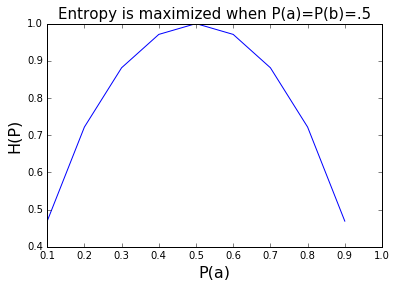

In [18]:
def entropy(p):
    return -sum(pi * math.log2(pi) for pi in p.values())

probs = np.arange(1,10) / 10
entropies = [entropy({'a': p, 'b': 1 - p}) for p in probs]
plt.figure()
plt.plot(probs, entropies)
plt.xlabel('P(a)', size=16)
plt.ylabel('H(P)', size=16)
plt.title('Entropy is maximized when P(a)=P(b)=.5', size=15)
plt.show()

**Coding theory:**
- The goal of data compression: represent each object with as few bits as possible.
- Let $C(x)$ be the code for object $x$
  - e.g., $C(6) = 0110$
- Let $l(C(x))$ be the length of the code (e.g., 4 bits)
- Then the expected length of the code for any object is:
  $$ E(l(c)) = \sum_x l(C(x))P(x)$$
- Entropy of $P(x)$ determines amount of compression possible
  - E.g., consider flipping two coins.
  - If fair coins (high entropy)
    - $P(H,H) = P(H,T) = P(T,H) = P(T,T) = .25$
    - Each outcome represneted as two bits (e.g., HH=11)
  - If very biased (low entropy)
    - $P(H,H) = .9; P(H,T) = P(T,H) = P(T,T) = 0.03$
    - Can use variable length encoding.
      - E.g., use one bit for $[H,H]$, two bits for rest.

**Cross-entropy:**
- Measure of how well $Q$ approximates $P$
- Number of bits to encode objects with $Q$, rather than true distribution $P$

$$H(P, Q) = - \sum_i p(i) \log q(i) $$

**KL divergence KL(P||Q)** can be rewritten as cross-entropy minus entropy of P.

$$KL(P||Q) = H(P,Q) - H(P)$$

- How many *additional* bits are needed to encode data using $Q$ beyond that required if using the "true" distribution $P$?

Back to our problem:

$$KL(M_q||M_d) = H(M_q, M_d) - H(M_q)$$

How bad of an approximation to $M_q$ is $M_d$?



Summary:
- We can compare the query and document models to rank documents.
- The choice of distance function will affect ranking.

Let's compare the distance functions on a simple example.

{'b': 0.90000000000000002, 'a': 0.10000000000000001}
{'b': 0.80000000000000004, 'a': 0.20000000000000001}
{'b': 0.69999999999999996, 'a': 0.29999999999999999}
{'b': 0.59999999999999998, 'a': 0.40000000000000002}
{'b': 0.5, 'a': 0.5}
{'b': 0.40000000000000002, 'a': 0.59999999999999998}
{'b': 0.30000000000000004, 'a': 0.69999999999999996}
{'b': 0.19999999999999996, 'a': 0.80000000000000004}
{'b': 0.099999999999999978, 'a': 0.90000000000000002}


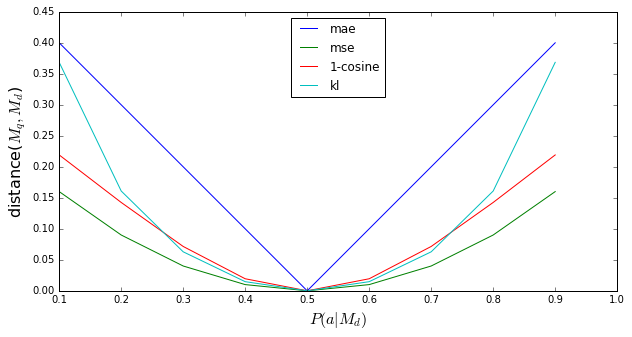

In [19]:
# How do these different measures compare?

def plot_measures(m_q2):
    maes = []
    mses = []
    cosines = []
    kls = []

    # Loop over possible document distributions.
    probs = np.arange(1,10) / 10
    for pi in probs:
        m_d2 = {'a': pi, 'b': 1 - pi}
        print(m_d2)
        maes.append(mae(m_q2, m_d2))
        mses.append(mse(m_q2, m_d2))
        cosines.append(cosine(m_q2, m_d2))
        kls.append(kl(m_q2, m_d2))

    # plot.
    plt.figure(figsize=(10,5))
    plt.plot(probs, maes, label='mae')
    plt.plot(probs, mses, label='mse')
    plt.plot(probs, cosines, label='1-cosine')
    plt.plot(probs, kls, label='kl')
    plt.xlabel('$P(a|M_d)$', size=16)
    plt.ylabel('distance($M_q, M_d$)', size=16)
    plt.legend(loc='best')
    plt.show()
    
plot_measures({'a': .5, 'b': .5})

{'b': 0.90000000000000002, 'a': 0.10000000000000001}
{'b': 0.80000000000000004, 'a': 0.20000000000000001}
{'b': 0.69999999999999996, 'a': 0.29999999999999999}
{'b': 0.59999999999999998, 'a': 0.40000000000000002}
{'b': 0.5, 'a': 0.5}
{'b': 0.40000000000000002, 'a': 0.59999999999999998}
{'b': 0.30000000000000004, 'a': 0.69999999999999996}
{'b': 0.19999999999999996, 'a': 0.80000000000000004}
{'b': 0.099999999999999978, 'a': 0.90000000000000002}


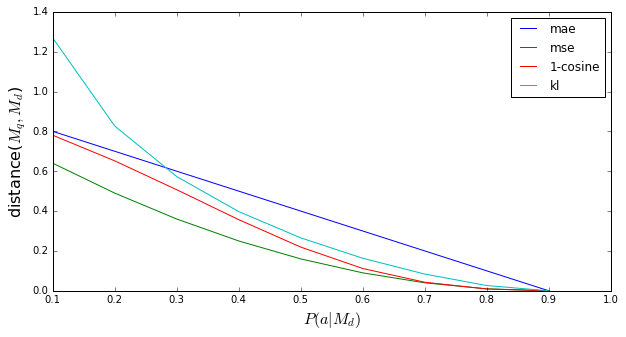

In [20]:
plot_measures({'a': .9, 'b': .1})

So, KL-divergence will place a larger penalty on documents that have a large mismatch for one query term.

## Language Models: Summary

<img src='lmsummary.png'>


**Possible shortcoming:**
- Language models are not optimized to have high evaluation metrics
- E.g., if we want to maximize Precision, Recall, MAP, nothing about language models directly optimize this.

Alternative:
- Machine learning: use historical data to optimize an evaluation metrics
